# Modelling with TensorFlow

Based on the findings made when exploring the data, now it's time to train a regression model to try and predict the housing prices

In [1]:
# Importing the libraries and checking TF version for compatibility
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.5.0


## Checking Hardware Configuration

Checking if TF has recognized the local GPU that will be used for training the model

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Mon May 31 22:26:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.47       Driver Version: 466.47       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:04:00.0  On |                  N/A |
|  0%   51C    P8    15W / 125W |   1170MiB /  6144MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading the dataset from TF

In [9]:
# Getting the data without train test split to conduct initial analysis of whole data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)
COLUMNS = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']     
len(x_train),len(x_test)

(404, 102)

In [10]:
# Joining both the features and the results to analyze
x = pd.DataFrame(x_train,columns=COLUMNS[:-1])
x2 = pd.DataFrame(x_test,columns=COLUMNS[:-1])
y = pd.DataFrame(y_train,columns=COLUMNS[-1:])
y2 = pd.DataFrame(y_test,columns=COLUMNS[-1:])
x['MEDV'] = y
x2['MEDV'] = y2
# Getting the basic statistical info from DataFrame
x.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817,22.395050
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545,9.210442
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000,16.675000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000,20.750000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500,24.800000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Checking Train/Test Split

Using SweetViz to guarantee that the train and test datasets are statistically similar so there are no biases that affect the training and evaluation of the model

In [12]:
import sweetviz as sv

compare_report = sv.compare([x,'Train'],[x2,'Test'],target_feat='MEDV')

[Step 3/3] Generating associations graph     |          | [  0%]   00:00 -> (? left)


Report .\Analysis\Compare_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



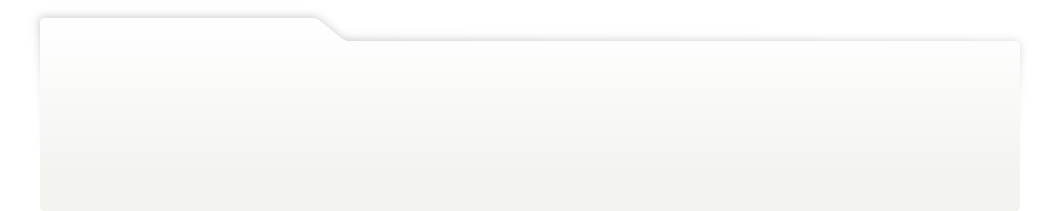
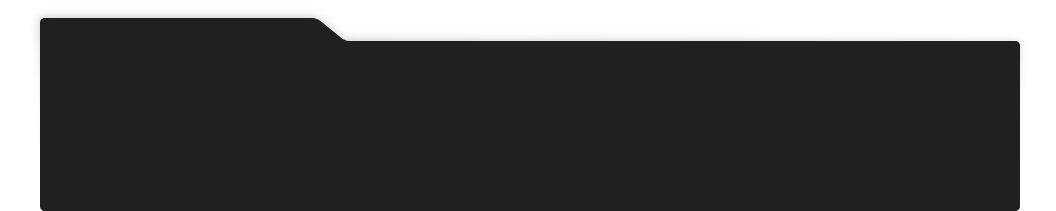
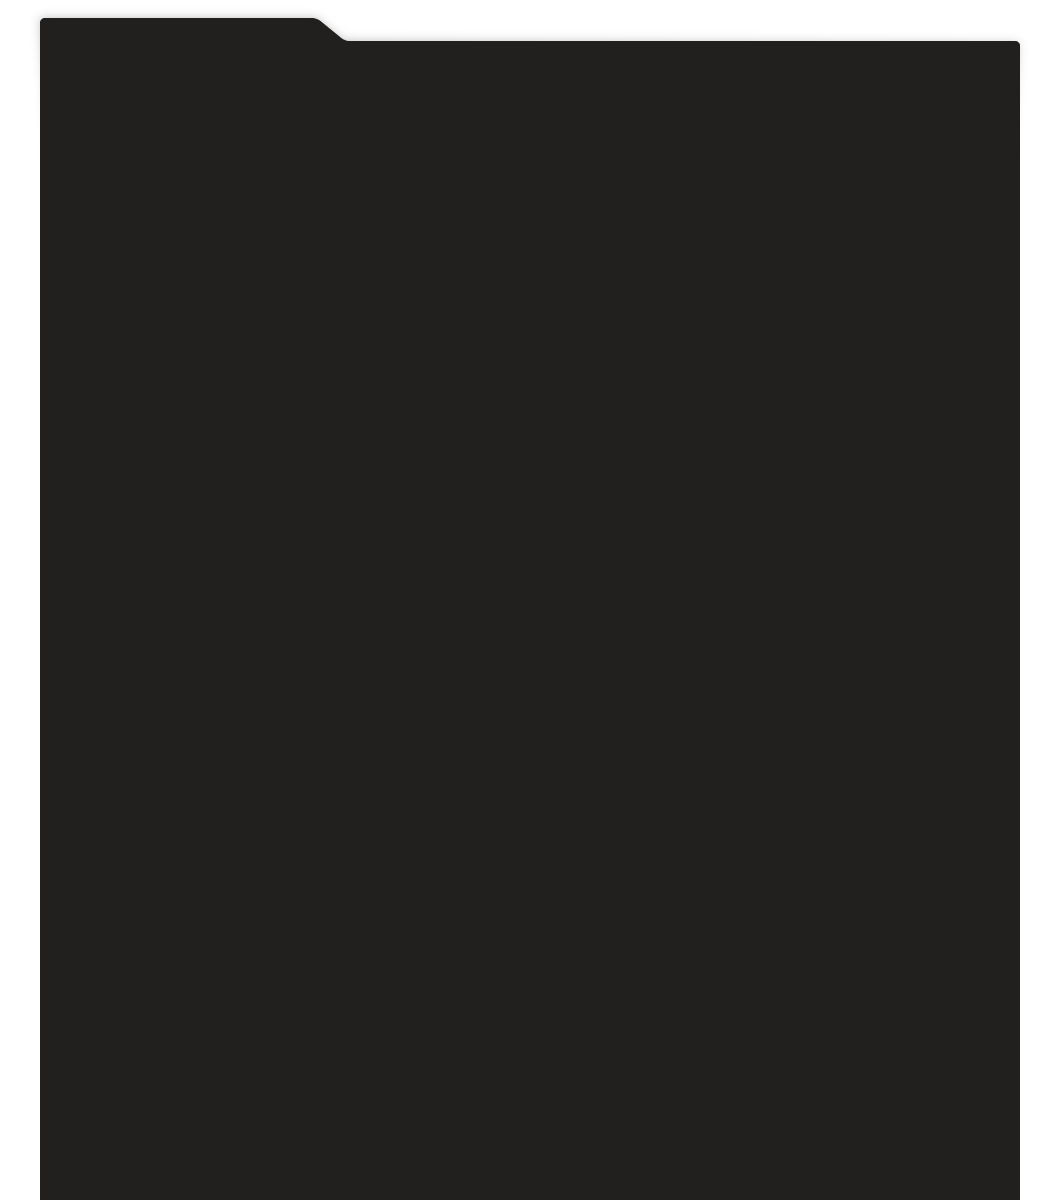
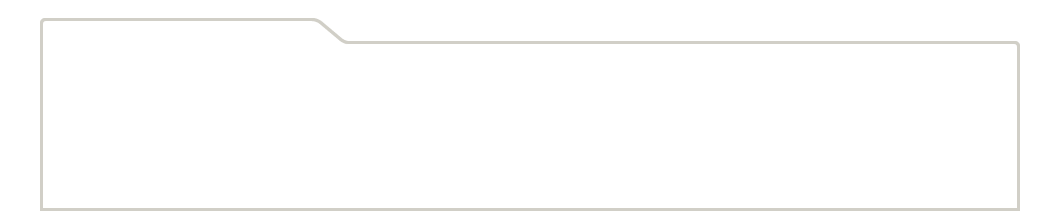
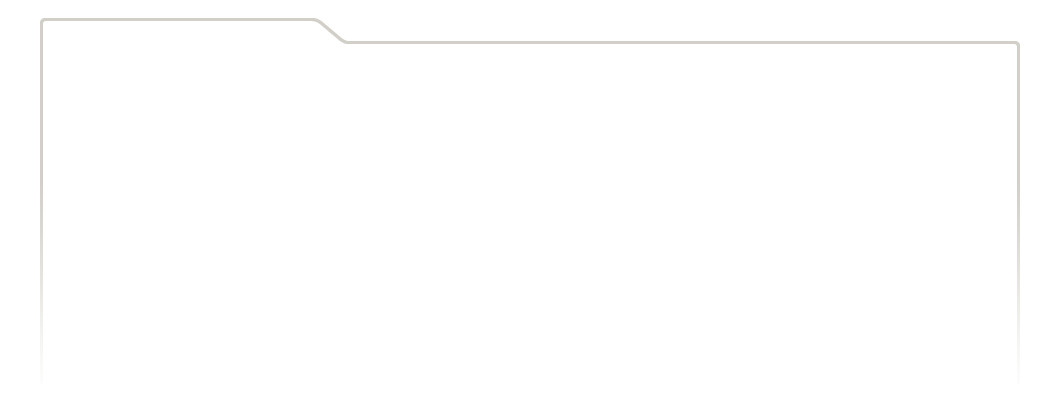
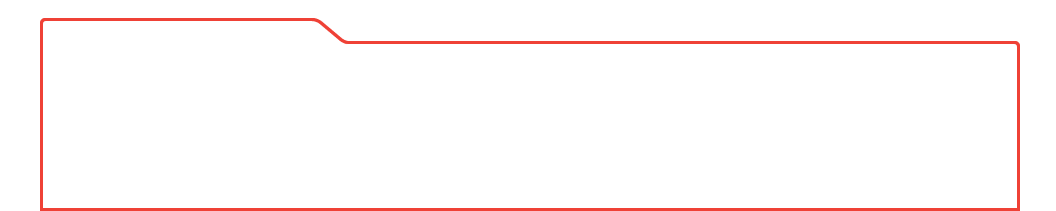
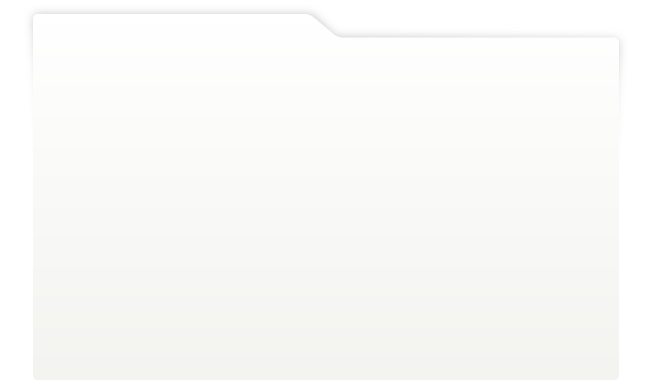
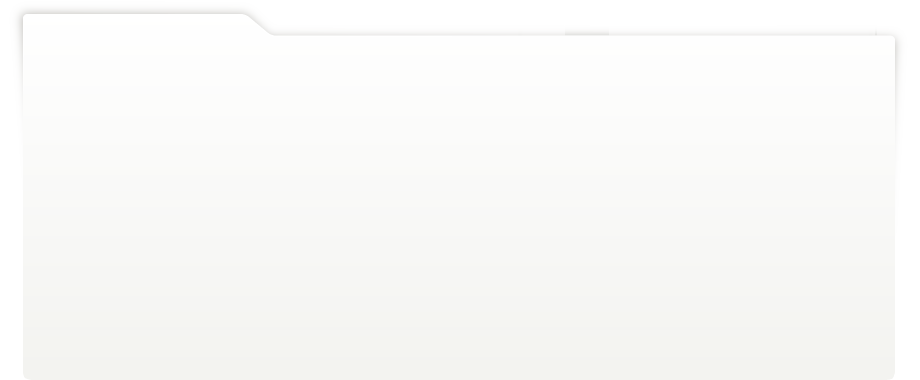
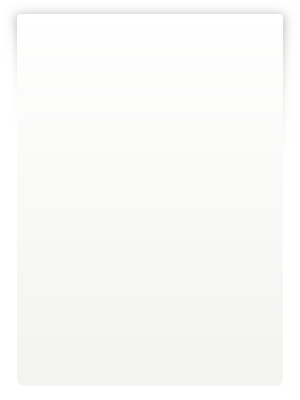
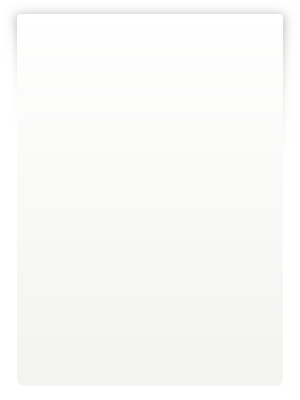
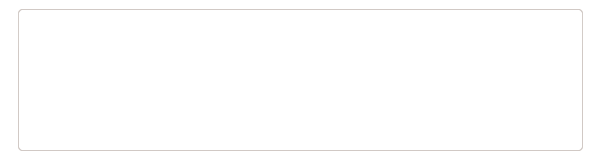
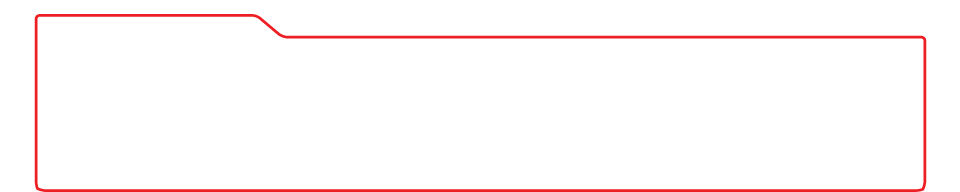
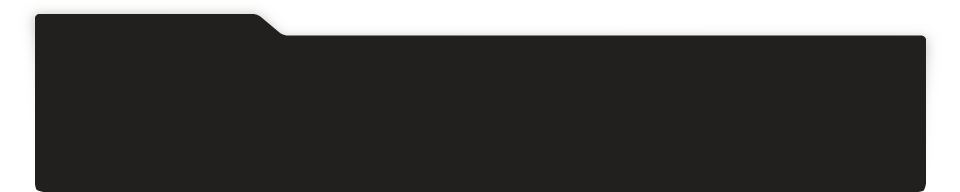
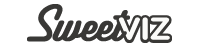
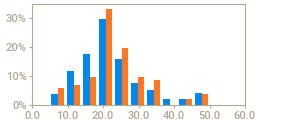
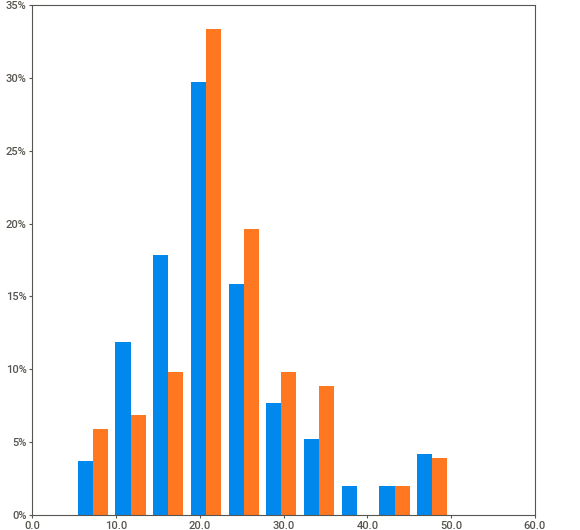
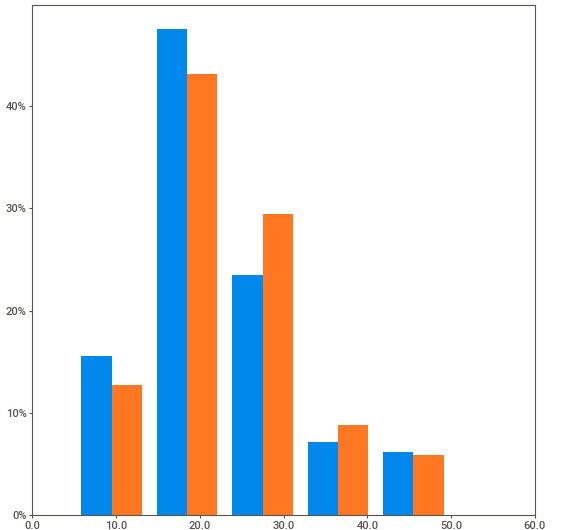
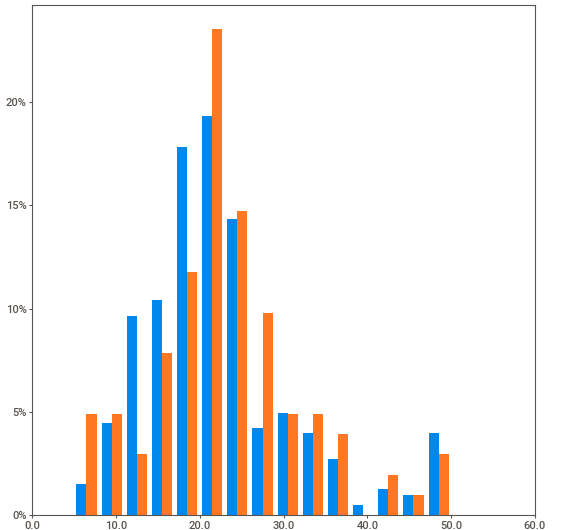
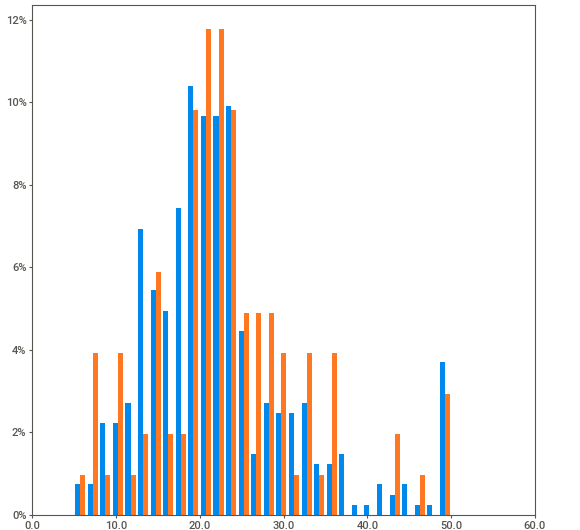
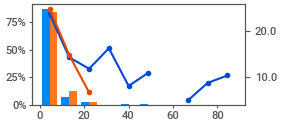
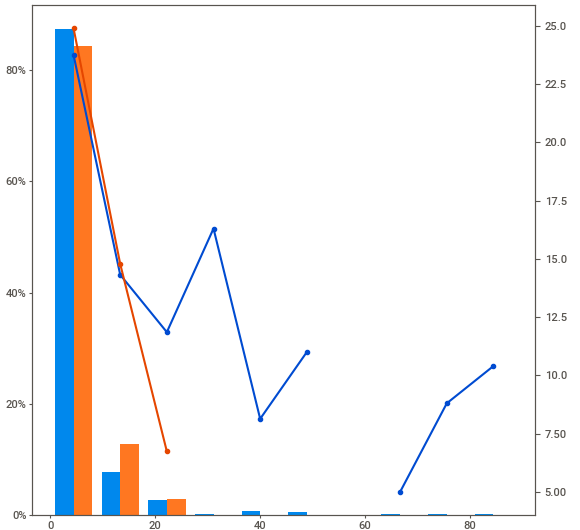
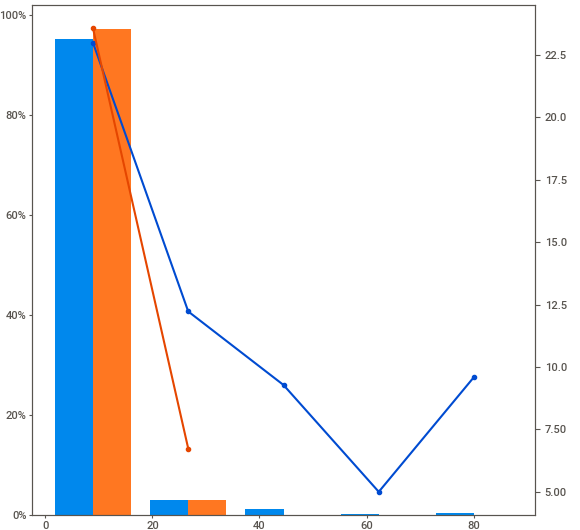
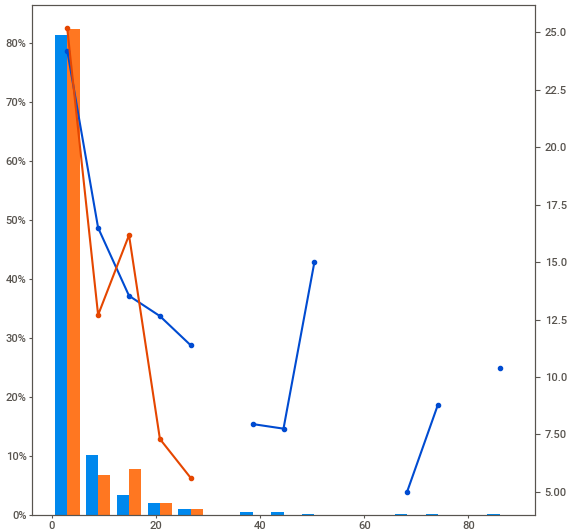
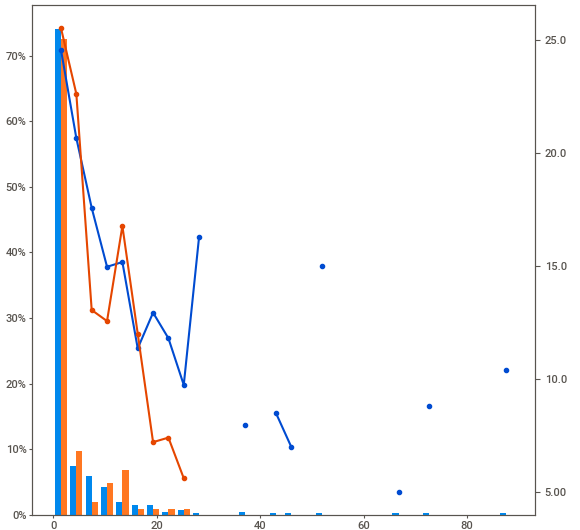
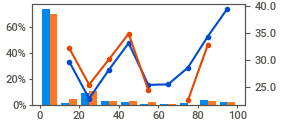
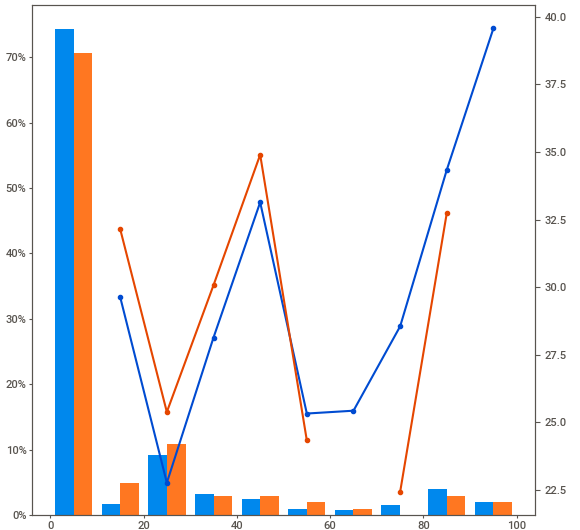
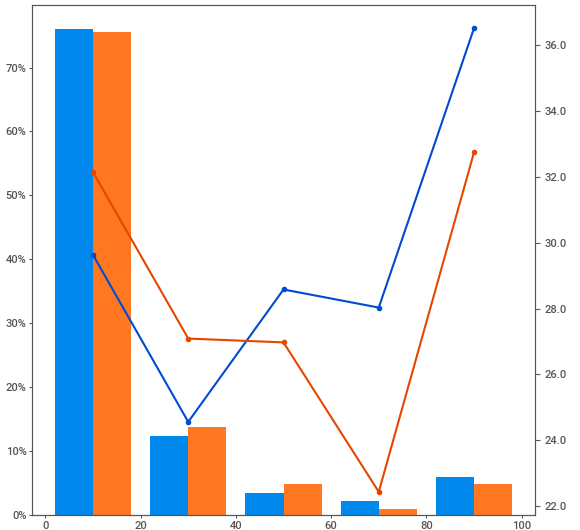
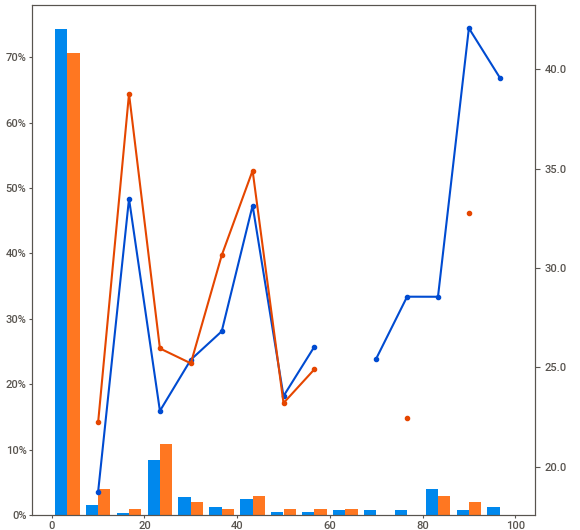
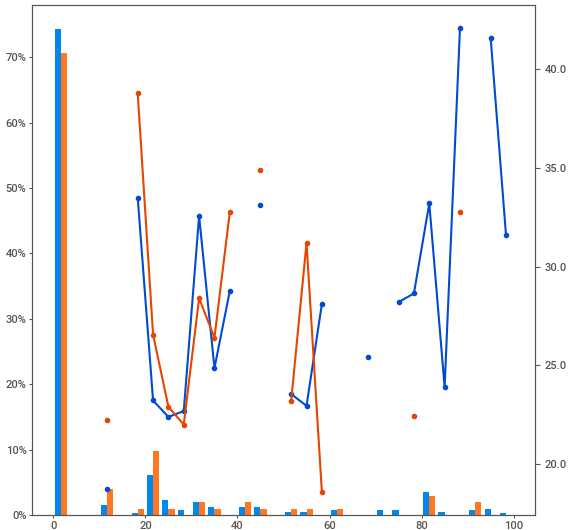
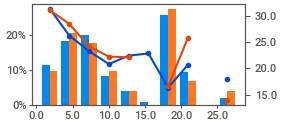
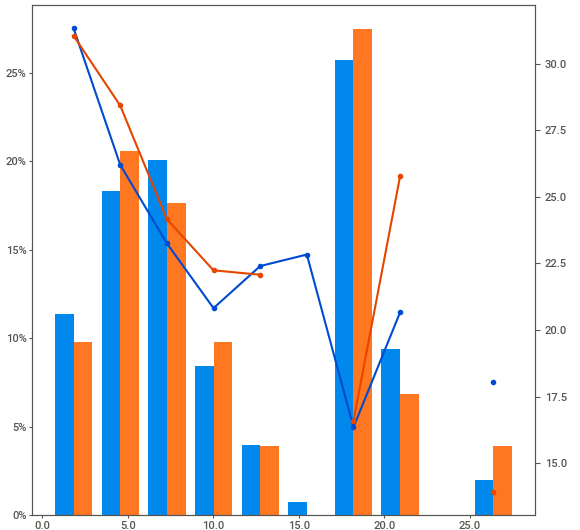
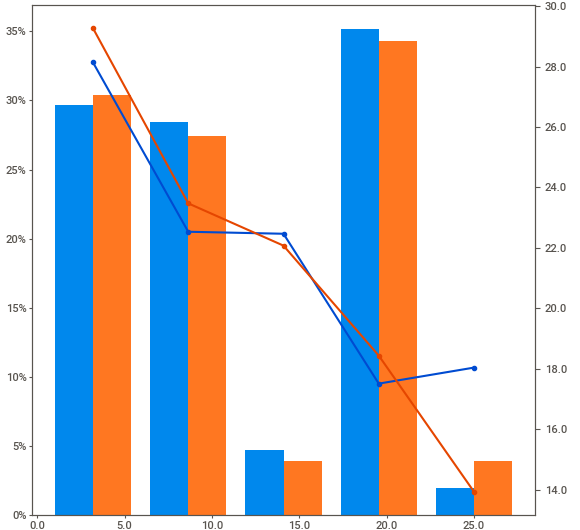
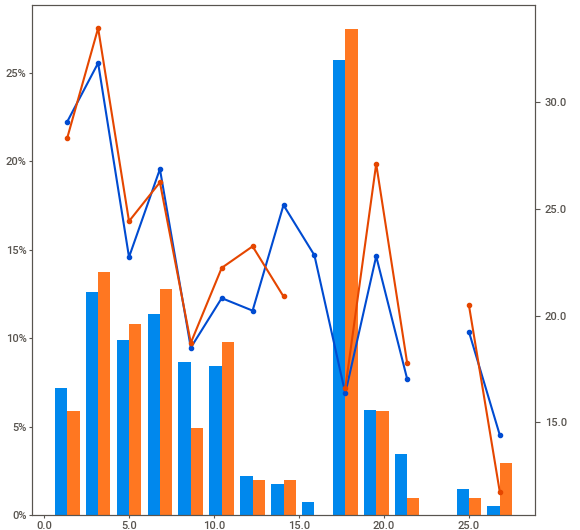
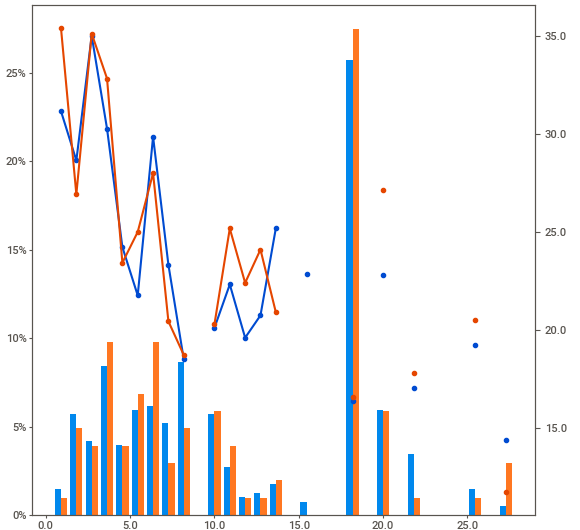
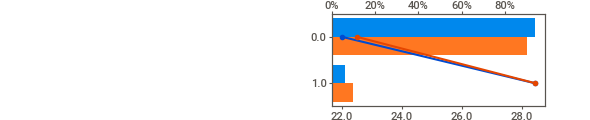
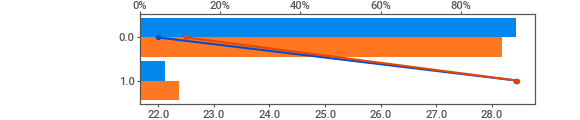
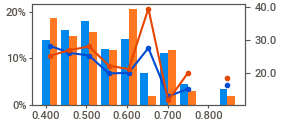
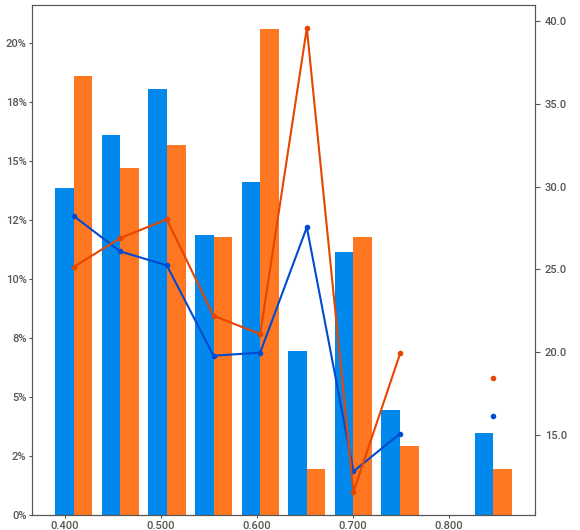
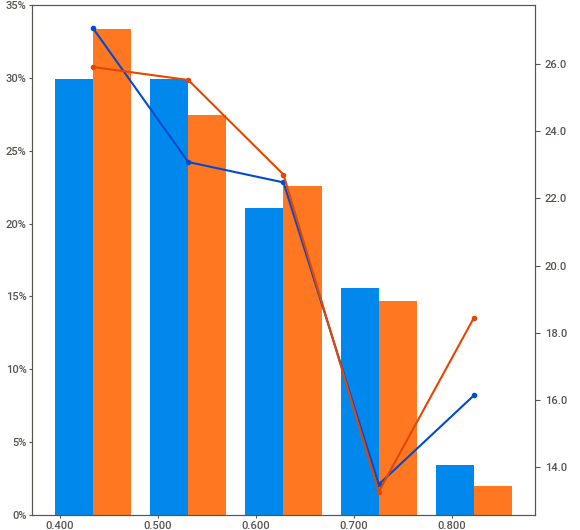
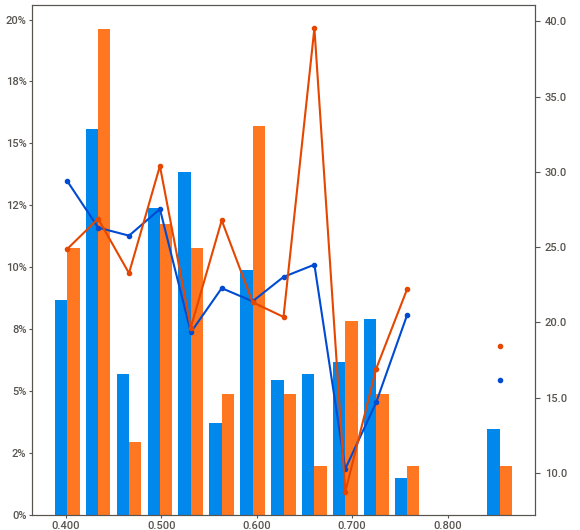
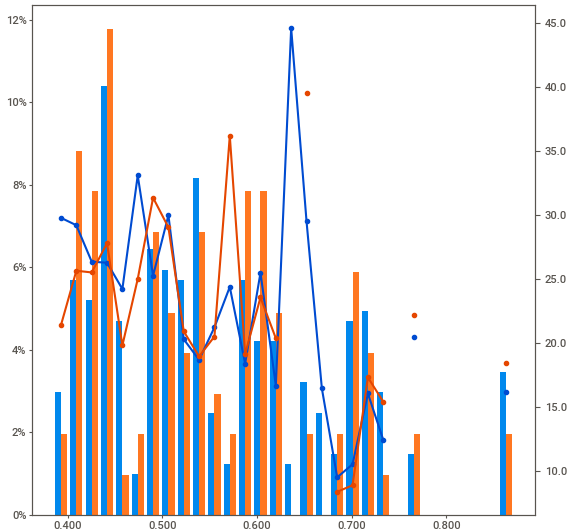
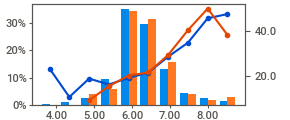
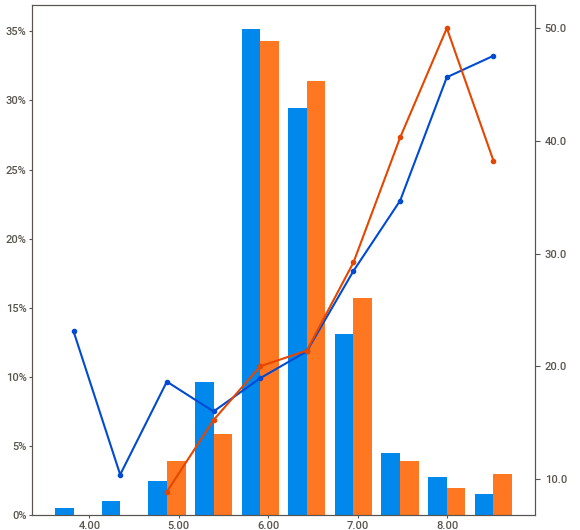
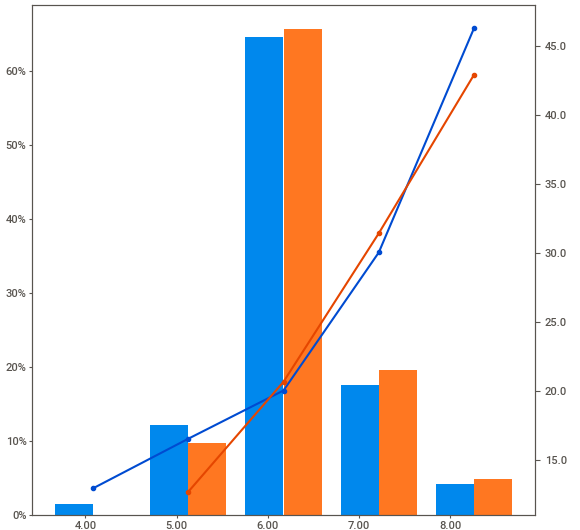
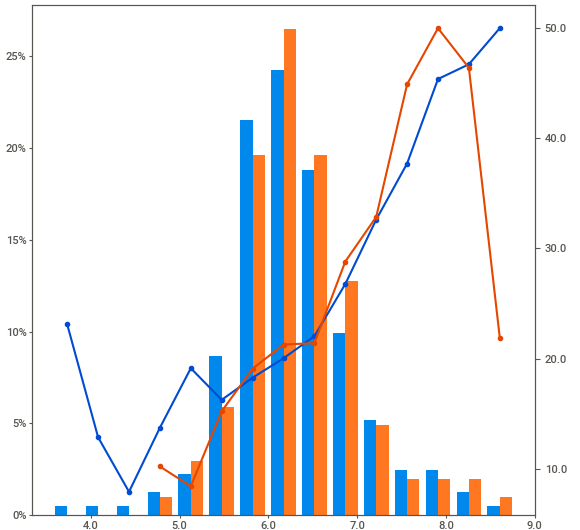
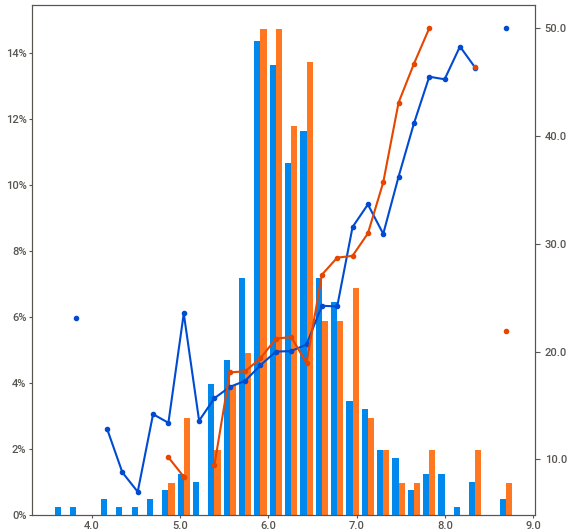
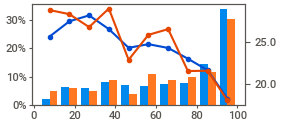
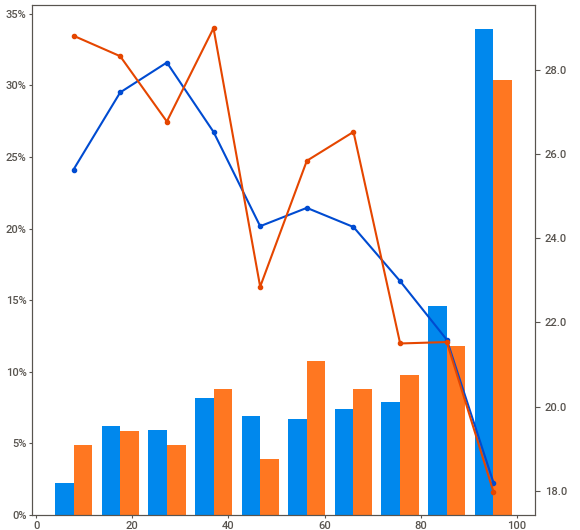
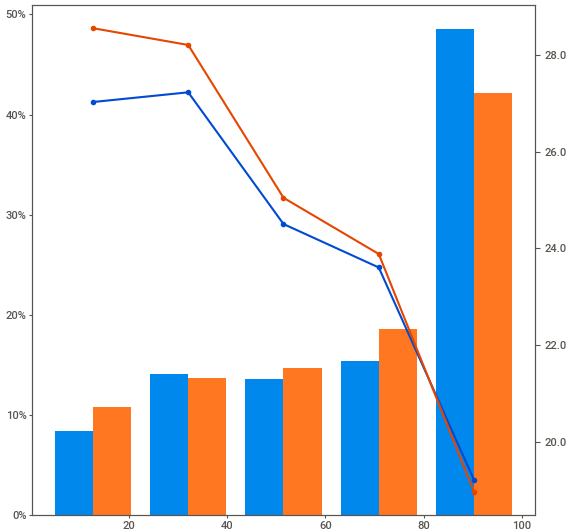
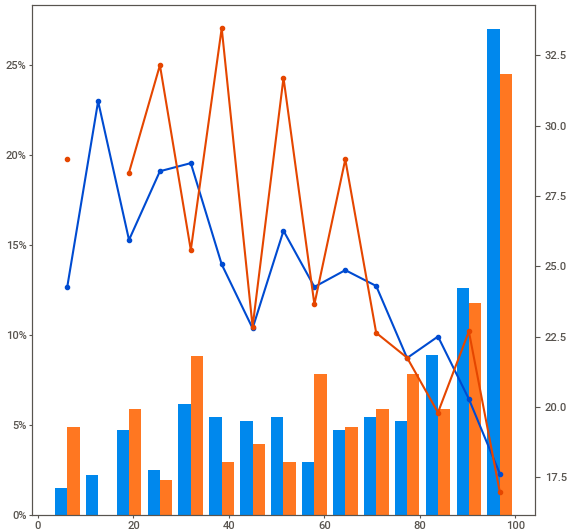
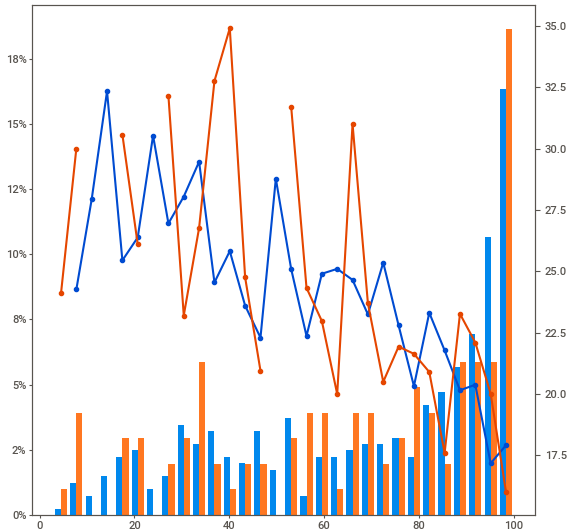
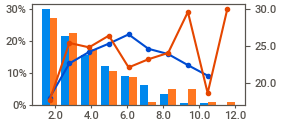
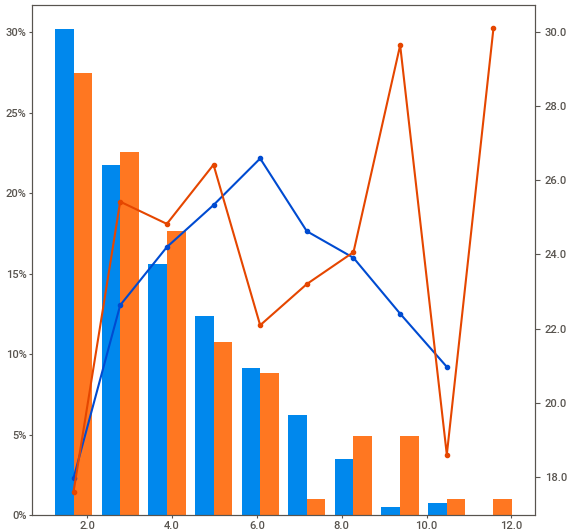
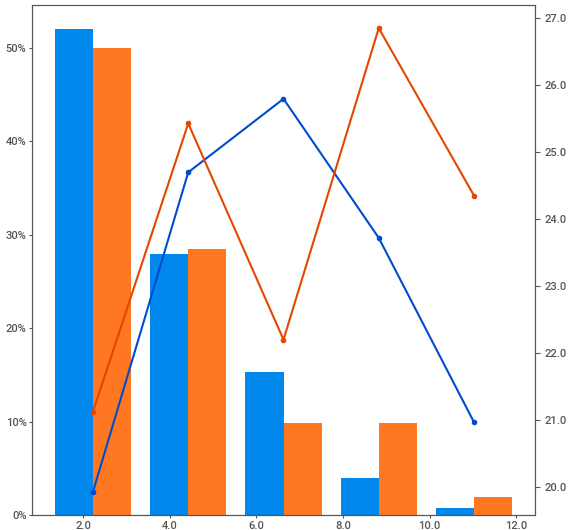
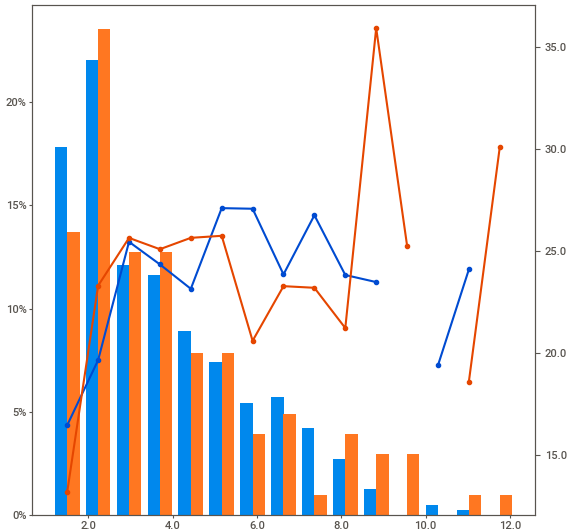
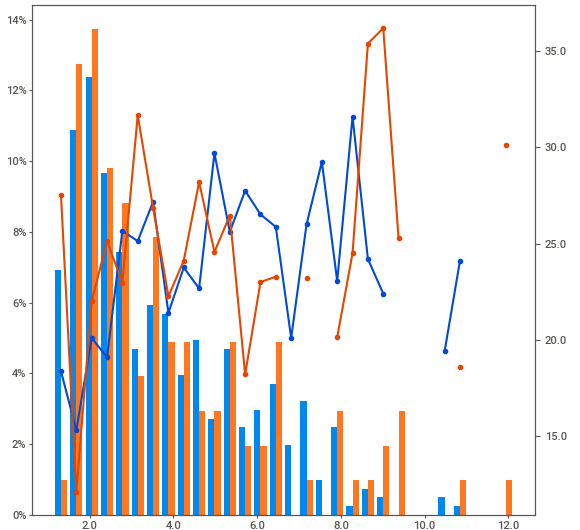
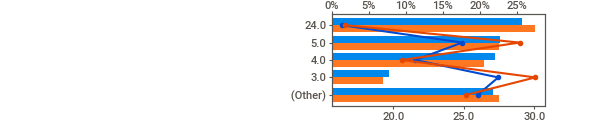
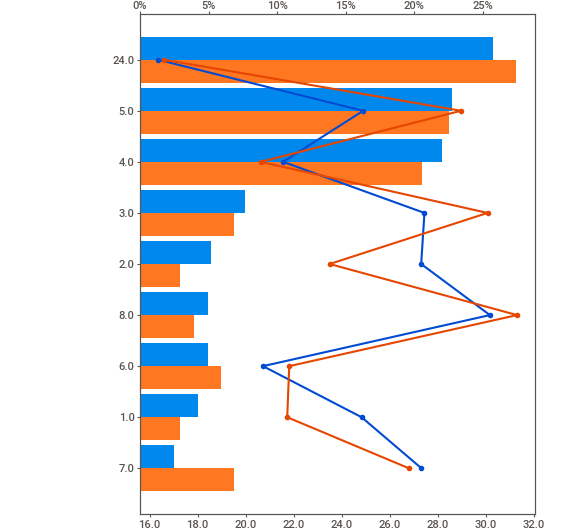
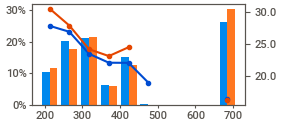
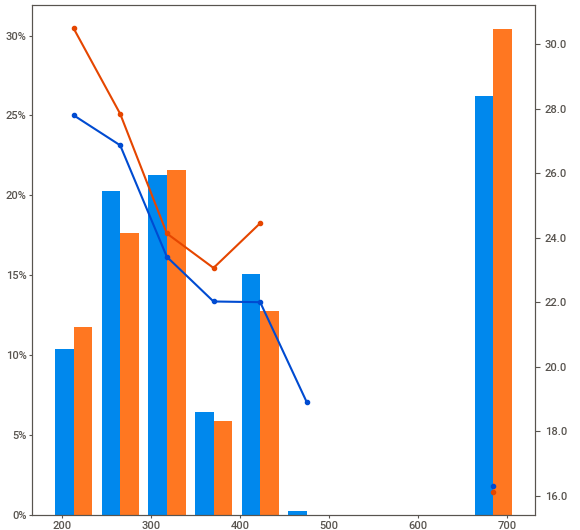
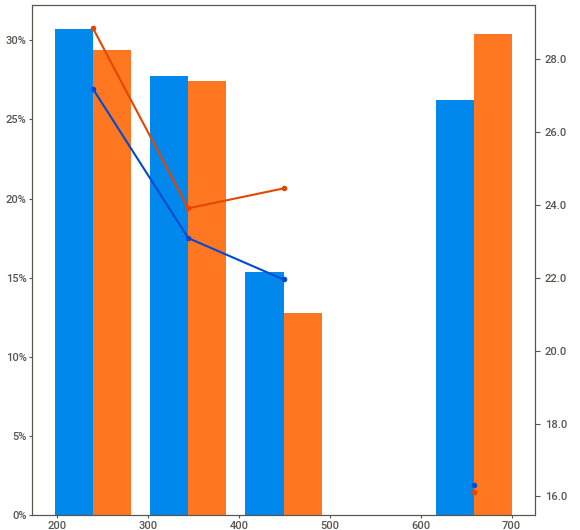
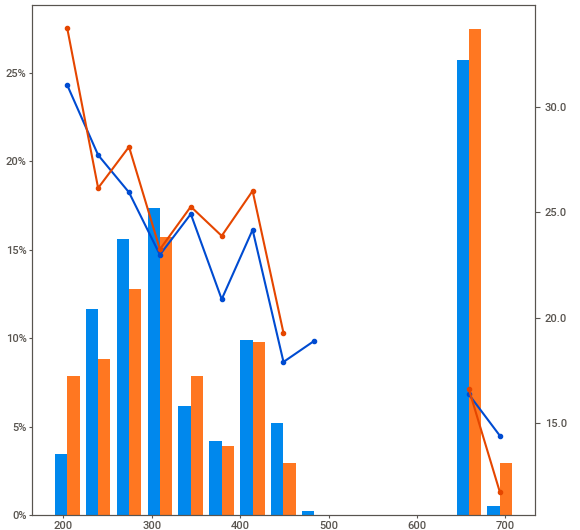
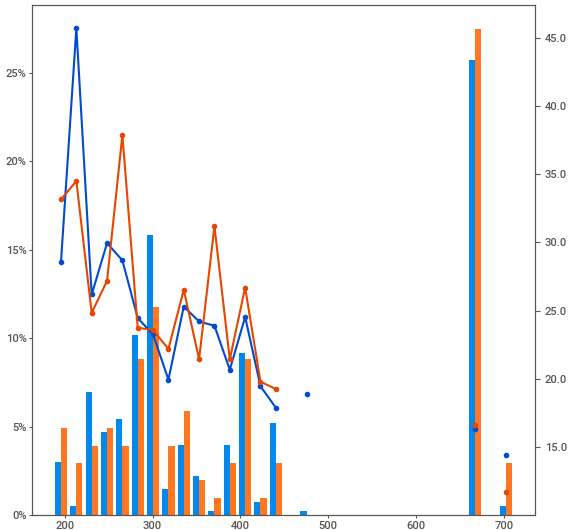
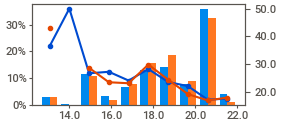
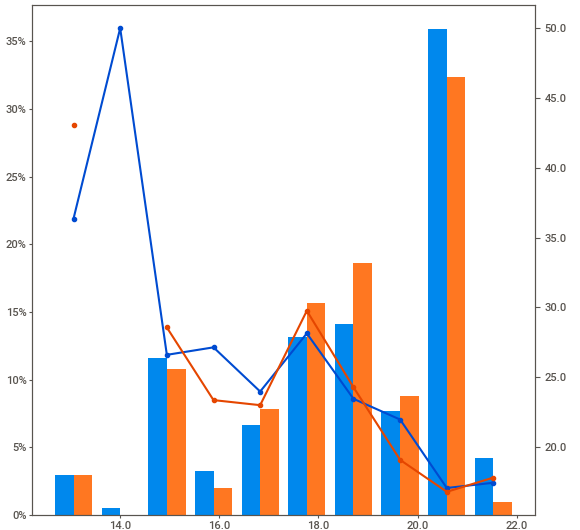
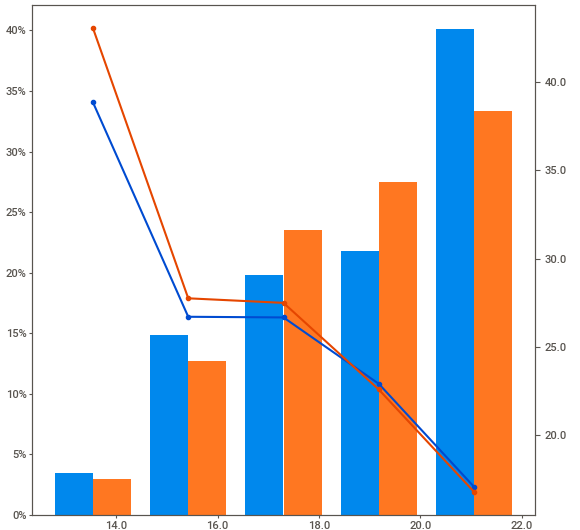
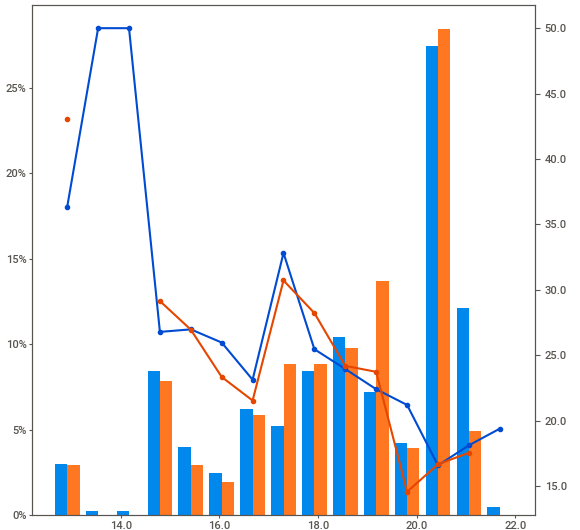
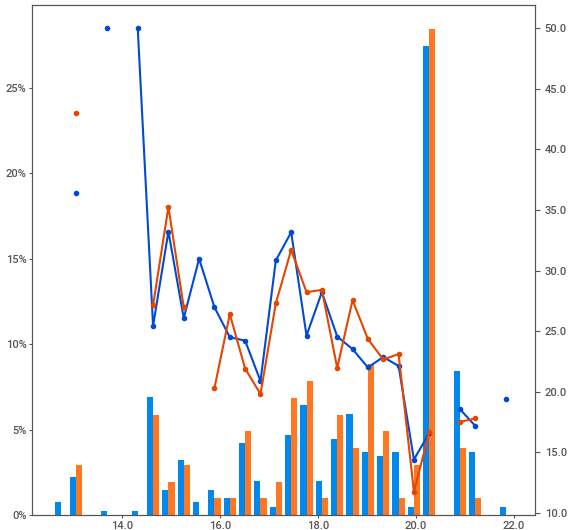
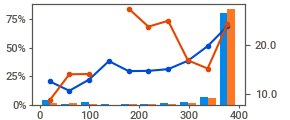
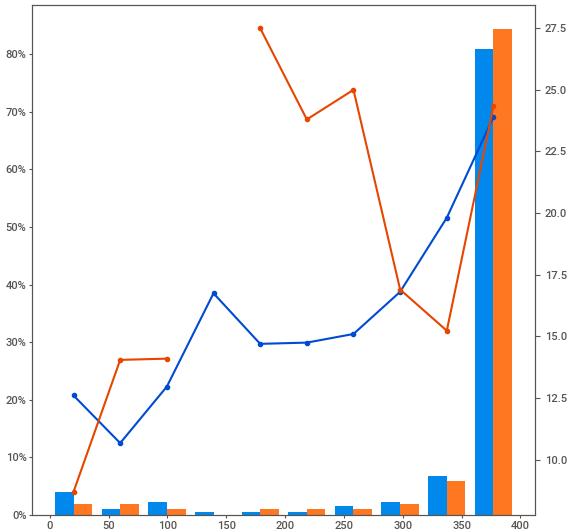
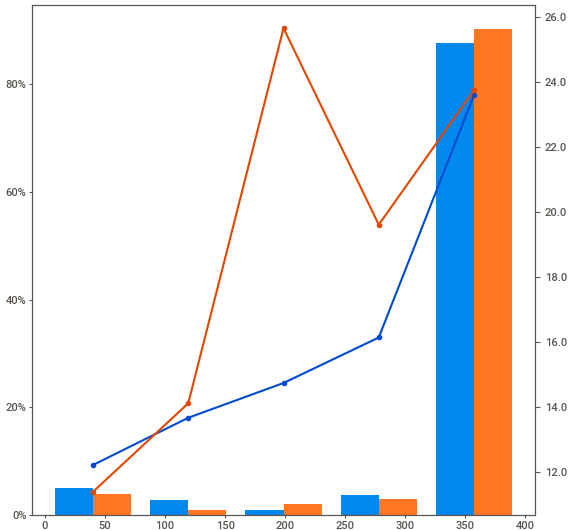
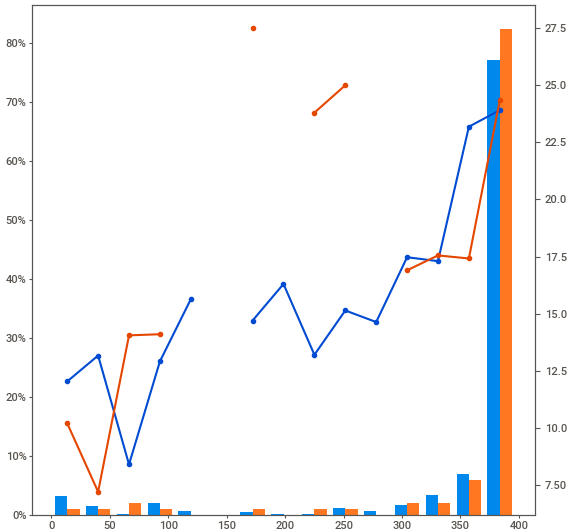
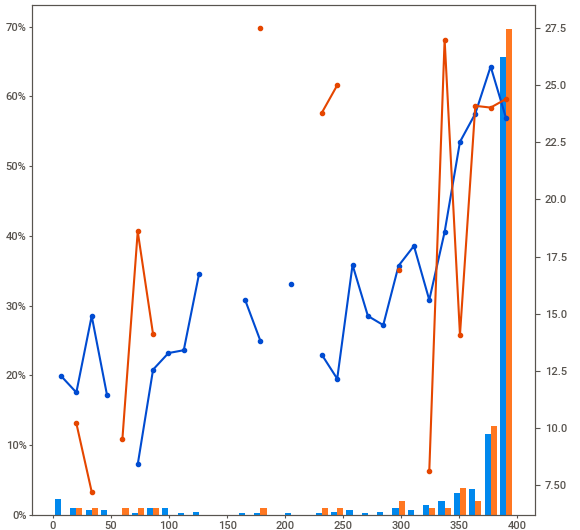
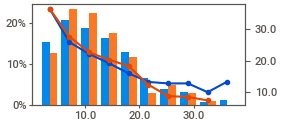
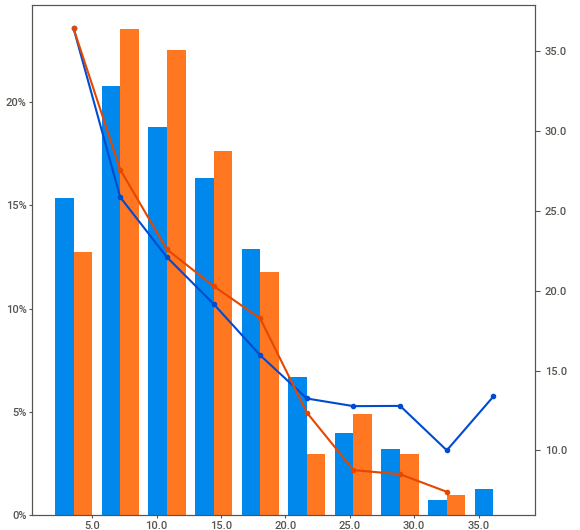
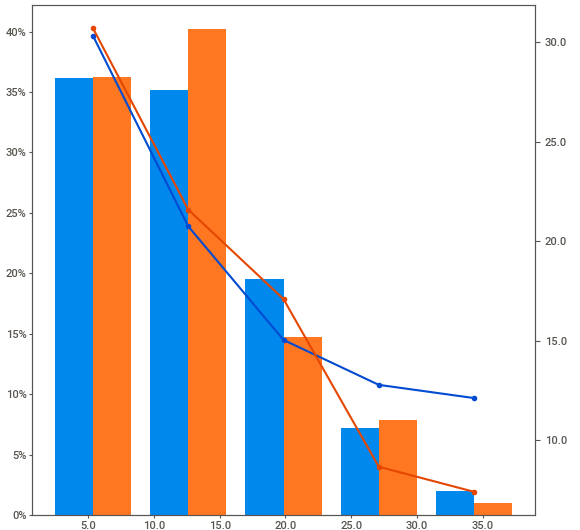
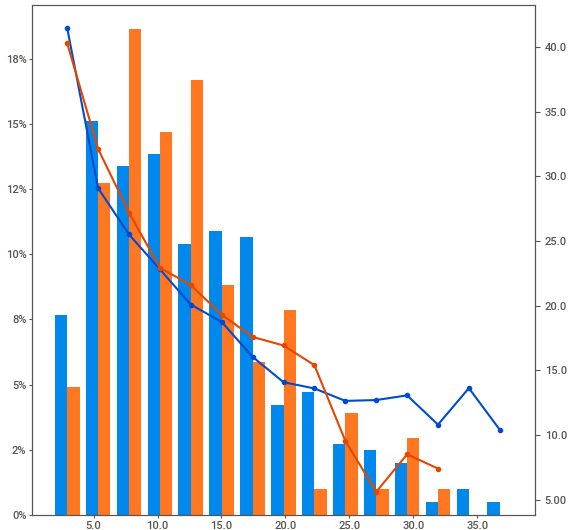
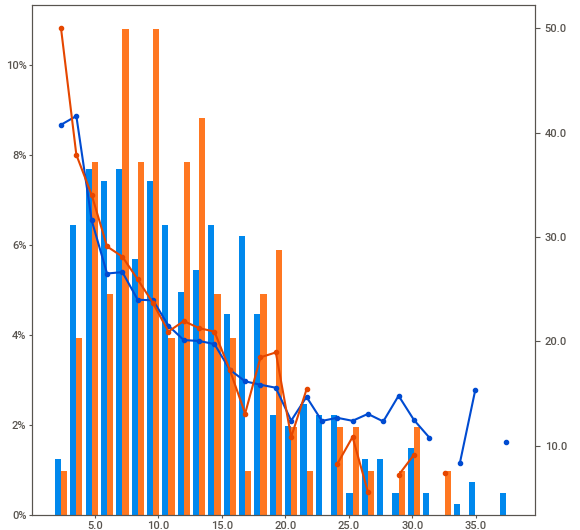
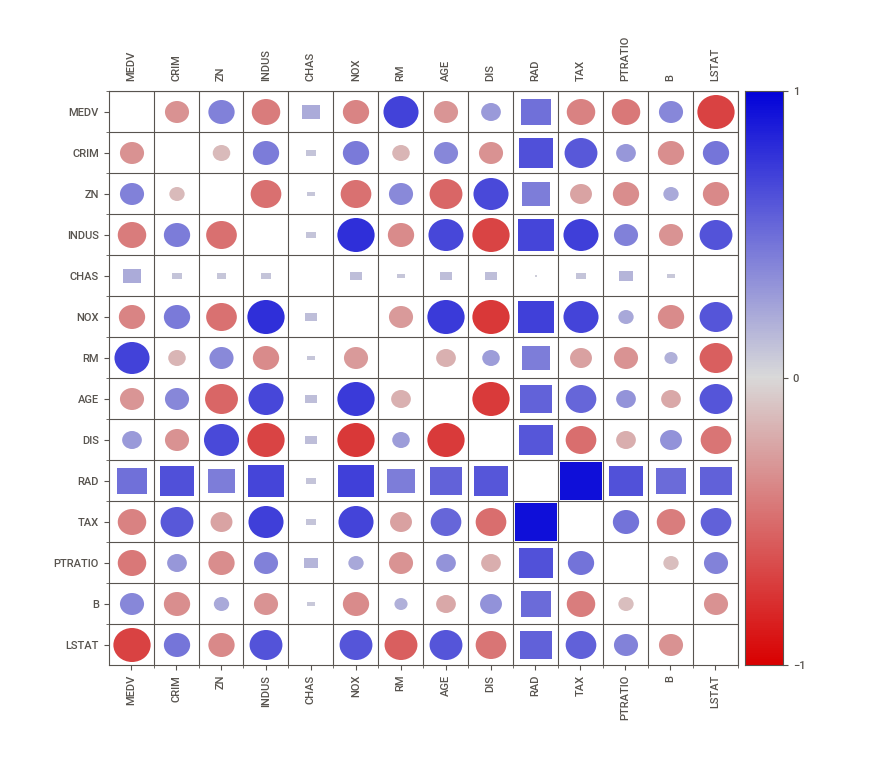
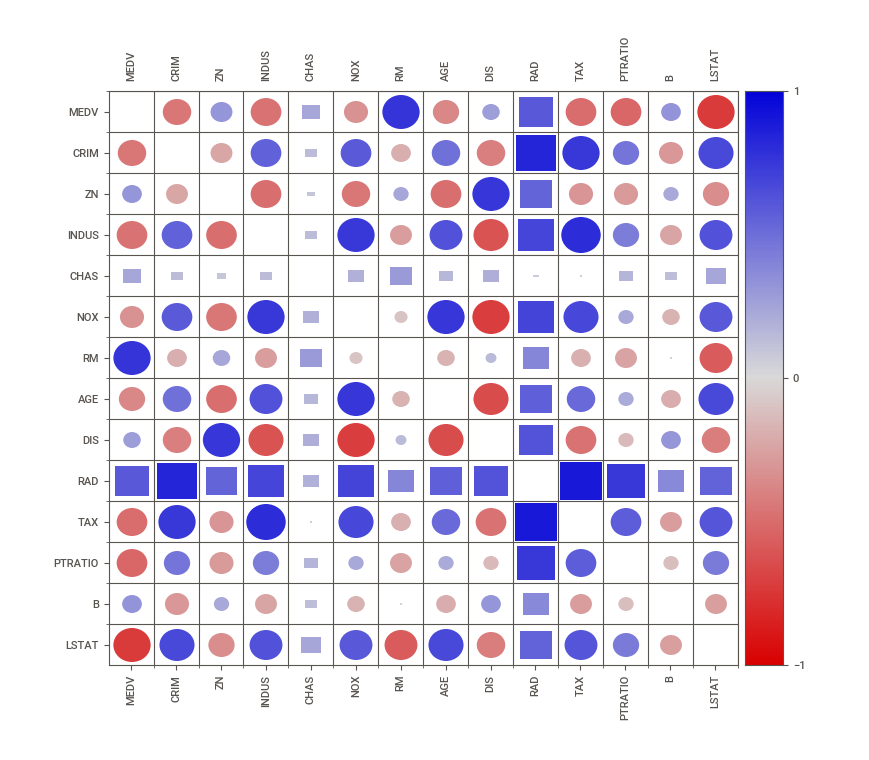

In [13]:
compare_report.show_html(filepath='.\\Analysis\\Compare_report.html')
compare_report.show_notebook()